In [5]:
import tensorflow as tf 
import numpy as np
import cv2
from skimage.color import rgb2gray
from tensorflow import keras
from model import load_model
from image_utils import imagenet_utils
from explanation_models import gradcam,gradcam_robust,gradcam_plusplus,guided_backprop
import matplotlib.pyplot as plt

class gradcam():

    def __init__(self,model,layer_name,input_dim):
        self.gradcamModel= tf.keras.Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(layer_name).output, model.output])
        self.input_dim=input_dim
    
    def get_heatmap(self,img,index=None,CounterfactualExp=False):
 
        with tf.GradientTape() as tape:
            (layer_output, class_prediction) = self.gradcamModel(img) 
            if(index==None):
                index=tf.argmax(class_prediction[0])  # use the index with best score if none provided
            tape.watch(layer_output)
            loss = class_prediction[:,index]  # 
           
        gradients = tape.gradient(loss, layer_output) # gradient of y^c wrt to a^k of the covolution layer given as input
        # [1, 14, 14, 512]) same dimensions as the output of the last layer
        layer_output = layer_output.numpy()[0]
        if(CounterfactualExp):
            neuron_importance_weights=tf.reduce_mean(gradients, axis=(0, 1, 2)).numpy()
        else:
            neuron_importance_weights=tf.reduce_mean(gradients, axis=(0, 1, 2)).numpy()
        for i in range(neuron_importance_weights.shape[-1]):
          layer_output[:, :, i] *= neuron_importance_weights[i]
        gradcam = tf.reduce_mean(layer_output, axis=-1).numpy()
       
        
        
        if np.max(gradcam) == 0:
            gradcam = gradcam/(np.max(gradcam)+tf.keras.backend.epsilon())
        else:
            gradcam = gradcam/np.max(gradcam)    
        gradcam = tf.keras.activations.relu(gradcam)
        
        return gradcam

In [6]:
image_name='ILSVRC2012_val_00000013.JPEG'

folder='ILSVRC2012_img_val/'

model_name = 'VGG16'
test=load_model(model_name)
model=test.model
input_dim=test.input_dim
layer_name='block5_conv3'


g= gradcam(model,layer_name,input_dim)
heatmap_dict={}

img_path=os.path.join(folder,image_name)

img = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
array = keras.preprocessing.image.img_to_array(img)
array = np.expand_dims(array, axis=0)

preprocess_input = keras.applications.vgg16.preprocess_input

# decode_predictions = keras.applications.vgg16.decode_predictions
preprocessed_input=preprocess_input(array)
index=375
heatmap_lower_dim=g.get_heatmap(preprocessed_input,index)
heatmap = np.squeeze(heatmap_lower_dim)
heatmap = cv2.resize(heatmap, (array.shape[2], array.shape[1]))


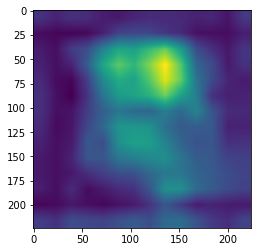

In [7]:

plt.imshow(heatmap)

In [8]:
from tf_explain.callbacks.grad_cam import GradCAM
# Load pretrained model or your own
model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=True)

# Load a sample image (or multiple ones)
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)
data = ([img], None)

# Start explainer
explainer = GradCAM()
grid = explainer.explain(data, model, class_index=375,layer_name=layer_name)  # 281 is the tabby cat index in ImageNet


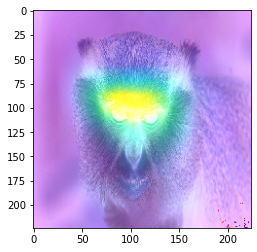

In [10]:
plt.imshow(grid)